ПЛАН:
 - Отослать посылку по задаче С
     - Посмотреть на сколько сложно работать со скоростью
 - Добавить признаков
    (каких?)
    - Точка пересечения траектории частицы с линией ускоритель 
        Или расстояние от прямой траектории до прямой ускоритель
    - Апроксимация траектории параболой (есть две точки) -> ускорение частицы
    - Там есть ошибка MatchedHit_D{X,Y,Z}[N], значит для угла и ошибки от траетории можно построить оценку сверху и 
        оценку снизу
    - Скорости 

In [1]:
import scoring

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# from matplotlib import pyplot as plt
# %matplotlib inline

In [2]:
# del scoring

In [3]:
from xgboost import XGBClassifier

Путь к выборке

In [4]:
path = '../data/'

In [5]:
%%time
df_train = pd.read_csv(path+'train_v2_merged.csv')
df_test  = pd.read_csv(path+'test_public_v2.csv')

CPU times: user 1min 38s, sys: 7.17 s, total: 1min 45s
Wall time: 1min 46s


Разделим на train и validation

In [6]:
%%time
df_train_part, df_validation = train_test_split(df_train, test_size=0.25, shuffle=True, random_state = 42)

CPU times: user 6.93 s, sys: 753 ms, total: 7.68 s
Wall time: 7.68 s


In [7]:
def calculate_angle(df):
    """ 
        params: 
            df - df with keys MatchedHit_{X, Y, Z}[{0,1 , 2}]
        return 
            np.array
    """
    x1 = (df['MatchedHit_X[1]'] - df['MatchedHit_X[0]'],\
          df['MatchedHit_Y[1]'] - df['MatchedHit_Y[0]'],\
          df['MatchedHit_Z[1]'] - df['MatchedHit_Z[0]'])

    x2 = (df['MatchedHit_X[2]'] - df['MatchedHit_X[1]'],\
          df['MatchedHit_Y[2]'] - df['MatchedHit_Y[1]'],\
          df['MatchedHit_Z[2]'] - df['MatchedHit_Z[1]'])

    scalar12 = np.sum([i*j for i,j in zip(x1, x2)], axis = 0)
    scalar11 = np.sum([i**2 for i in x1], axis = 0)
    scalar22 = np.sum([i**2 for i in x2], axis = 0)

    return np.arccos(scalar12/np.sqrt(scalar11*scalar22))*180/np.pi


def calc_ind_closure(ind, start_ind=0):
    def calculate_angle_ind(df):
        """ 
            params: 
                df - df with keys MatchedHit_{X, Y, Z}[{0,1 , 2}]
            return 
                np.array
        """
        i0 = start_ind
        i1 = start_ind + 1
        i2 = start_ind + 2
        x1 = (df['MatchedHit_X[%i]' % i1] - df['MatchedHit_X[%i]' % i0],\
              df['MatchedHit_Y[%i]' % i1] - df['MatchedHit_Y[%i]' % i0],\
              df['MatchedHit_Z[%i]' % i1] - df['MatchedHit_Z[%i]' % i0])

        x2 = (df['MatchedHit_X[%i]' % i2] - df['MatchedHit_X[%i]' % i1],\
              df['MatchedHit_Y[%i]' % i2] - df['MatchedHit_Y[%i]' % i1],\
              df['MatchedHit_Z[%i]' % i2] - df['MatchedHit_Z[%i]' % i1])

        scalar12 = np.sum([i*j for i,j in zip(x1, x2)], axis = 0)
        scalar11 = np.sum([i**2 for i in x1], axis = 0)
        scalar22 = np.sum([i**2 for i in x2], axis = 0)

        return np.arccos(scalar12/np.sqrt(scalar11*scalar22))*180/np.pi
    return calculate_angle_ind

    

def get_column_lengths_trajectory(data):
    """
      Длинна траектории, чтобы это не значило
    """
    lengths = np.ones(len(data)) * 4
    for i in range(3, -1, -1):
        indices = np.where(data['MatchedHit_Z[{}]'.format(i)] < -9800)[0]
        lengths[indices] = i 
    return lengths

def calc_diff_btw_trajectory_and_extr(data):
    diff_columns = {}
    res = np.zeros(len(data))
    for i in range(4):
        diff_columns[i] = {}
        for l in ['X', 'Y']:
            diff_columns[i][l] = (data["MatchedHit_%s[%i]"%(l, i)] - data["Lextra_%s[%i]"%(l, i)])**2
        res += np.sqrt(diff_columns[i]['X'] + diff_columns[i]['Y'])
    return res

# FEATURES

In [8]:
from sklearn.base import TransformerMixin, ClassifierMixin
class FeatureTransformer(TransformerMixin):
    SIMPLE_FEATURES = ['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]',
                       'avg_cs[1]', 'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
                       'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
                       'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
                       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
                       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
                       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
                       'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
                       'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
                       'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
                       'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
                       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
                       'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]',
                       'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]',
                       'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]', 'Lextra_Y[1]',
                       'Lextra_Y[2]', 'Lextra_Y[3]', 'NShared', 'Mextra_DX2[0]',
                       'Mextra_DX2[1]', 'Mextra_DX2[2]', 'Mextra_DX2[3]', 'Mextra_DY2[0]',
                       'Mextra_DY2[1]', 'Mextra_DY2[2]', 'Mextra_DY2[3]', 'FOI_hits_N', 'PT', 'P',
                       'weight']
    
    CREATE_NEW_FEATURES = True
    
    def create_new_features(self, data):
        for name, funct in zip(['angle0', 'angle1', 'traj_len', 'deff_exp_ext'],
                              [
#                                calculate_angle, 
                               calc_ind_closure(0),
                               calc_ind_closure(1),
                               get_column_lengths_trajectory, 
                               calc_diff_btw_trajectory_and_extr]):
            data[name] = funct(data)
            if not name in self.SIMPLE_FEATURES:
                self.SIMPLE_FEATURES.append(name)
        return data
    
    def base_transform(self, data, create_new_features):
        if create_new_features:
            data = self.create_new_features(data)
            
        return data[self.SIMPLE_FEATURES]
    
    def transform(self, data, y = None):       
        if self.CREATE_NEW_FEATURES:
            data = self.create_new_features(data)
            
        features =  self.SIMPLE_FEATURES.copy()
        features.remove('weight')
        return data[features]
    
    def fit_transform(self, data, y = None):
        if self.CREATE_NEW_FEATURES:
            data = self.create_new_features(data)
            
        return data[self.SIMPLE_FEATURES]
    

class ModelClass(ClassifierMixin):
    def fit(self, X, y, sample_weights = None):
        self.estimator = XGBClassifier(n_jobs=20)
        features = list(X.keys())
        if 'weight' in features:
            print('fitting, using weight')
            features.remove('weight')
            self.estimator.fit(X[features].get_values(), y.get_values(), sample_weight=X['weight'].get_values())
        else:
            print('fitting with out weight')
            self.estimator.fit(X.get_values(), y.get_values())
        return self
    
    def predict(self, X):
        features = list(X.keys())
        if 'weight' in features:
            features.remove('weight')
            return self.estimator.predict(X[features].get_values())
        else:
            return self.estimator.predict(X.get_values())
    
    def predict_proba(self, X):
        features = list(X.keys())
        if 'weight' in features:
            features.remove('weight')
            return self.estimator.predict_proba(X[features].get_values())
        else:
            return self.estimator.predict_proba(X.get_values())


clf = ModelClass()
transformer = FeatureTransformer()

model = Pipeline([('transformer', transformer),
                  ('clf', clf)])

In [9]:
set(df_train.keys())-set(df_test.keys())

{'kinWeight', 'label', 'particle_type', 'sWeight', 'weight'}

In [10]:
'weight' in df_train_part.keys()

True

In [11]:
# df_train

In [12]:
features = list(df_train.keys())
features.remove('label')
# features.remove('weight')
features.remove('particle_type')
target = ['label']

In [13]:
'weight' in features

True

In [14]:
%%time
model.fit(df_train_part[features], df_train_part[target])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


fitting, using weight


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 53min 22s, sys: 59.7 s, total: 54min 22s
Wall time: 3min 13s


Pipeline(memory=None,
     steps=[('transformer', <__main__.FeatureTransformer object at 0x7fe451f74c88>), ('clf', <__main__.ModelClass object at 0x7fe451f74d30>)])

In [15]:
y_predict_proba = model.predict_proba(df_validation[features])[:, 1]
y_predict = model.predict(df_validation[features])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_predict, df_validation.label.values))
print('rejection90:\t', str(scoring.rejection90(df_validation.label.values, 
                                                y_predict_proba, 
                                                sample_weight=df_validation.weight.values)))

             precision    recall  f1-score   support

          0       0.72      0.19      0.30    408686
          1       0.74      0.97      0.84    952741

avg / total       0.73      0.73      0.67   1361427

rejection90:	 0.7001187352573887


In [17]:
# model.steps[0][1].SIMPLE_FEATURES.remove('weight')
predictions = model.predict_proba(df_test)[:, 1]
pd.DataFrame(data={"prediction": predictions}, index=df_test.index).to_csv(
    "/nis/idao/results/xgb_2_angles__new_features.csv", index_label='id')

#### RESULTS:
    ====[  2  ]=============================================================
    all numeric features + 4 features + xgb with our metric  [03.02.18 21:39]

    precision    recall  f1-score   support

              0       0.72      0.19      0.30    408686
              1       0.74      0.97      0.84    952741

    avg / total       0.73      0.73      0.67   1361427

    rejection90:	 0.7001187352573887
    

## FEATURE IMPORTANCE

In [18]:
df_train.keys()

Index(['id', 'ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]',
       'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
       'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
       'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
       'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
       'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
       'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
       'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
       'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]',
       'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]',
       'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]', 'L

In [19]:
import pickle
pickle.dump(model, open('../results/model4feature_2_angles.pickle', 'wb'))

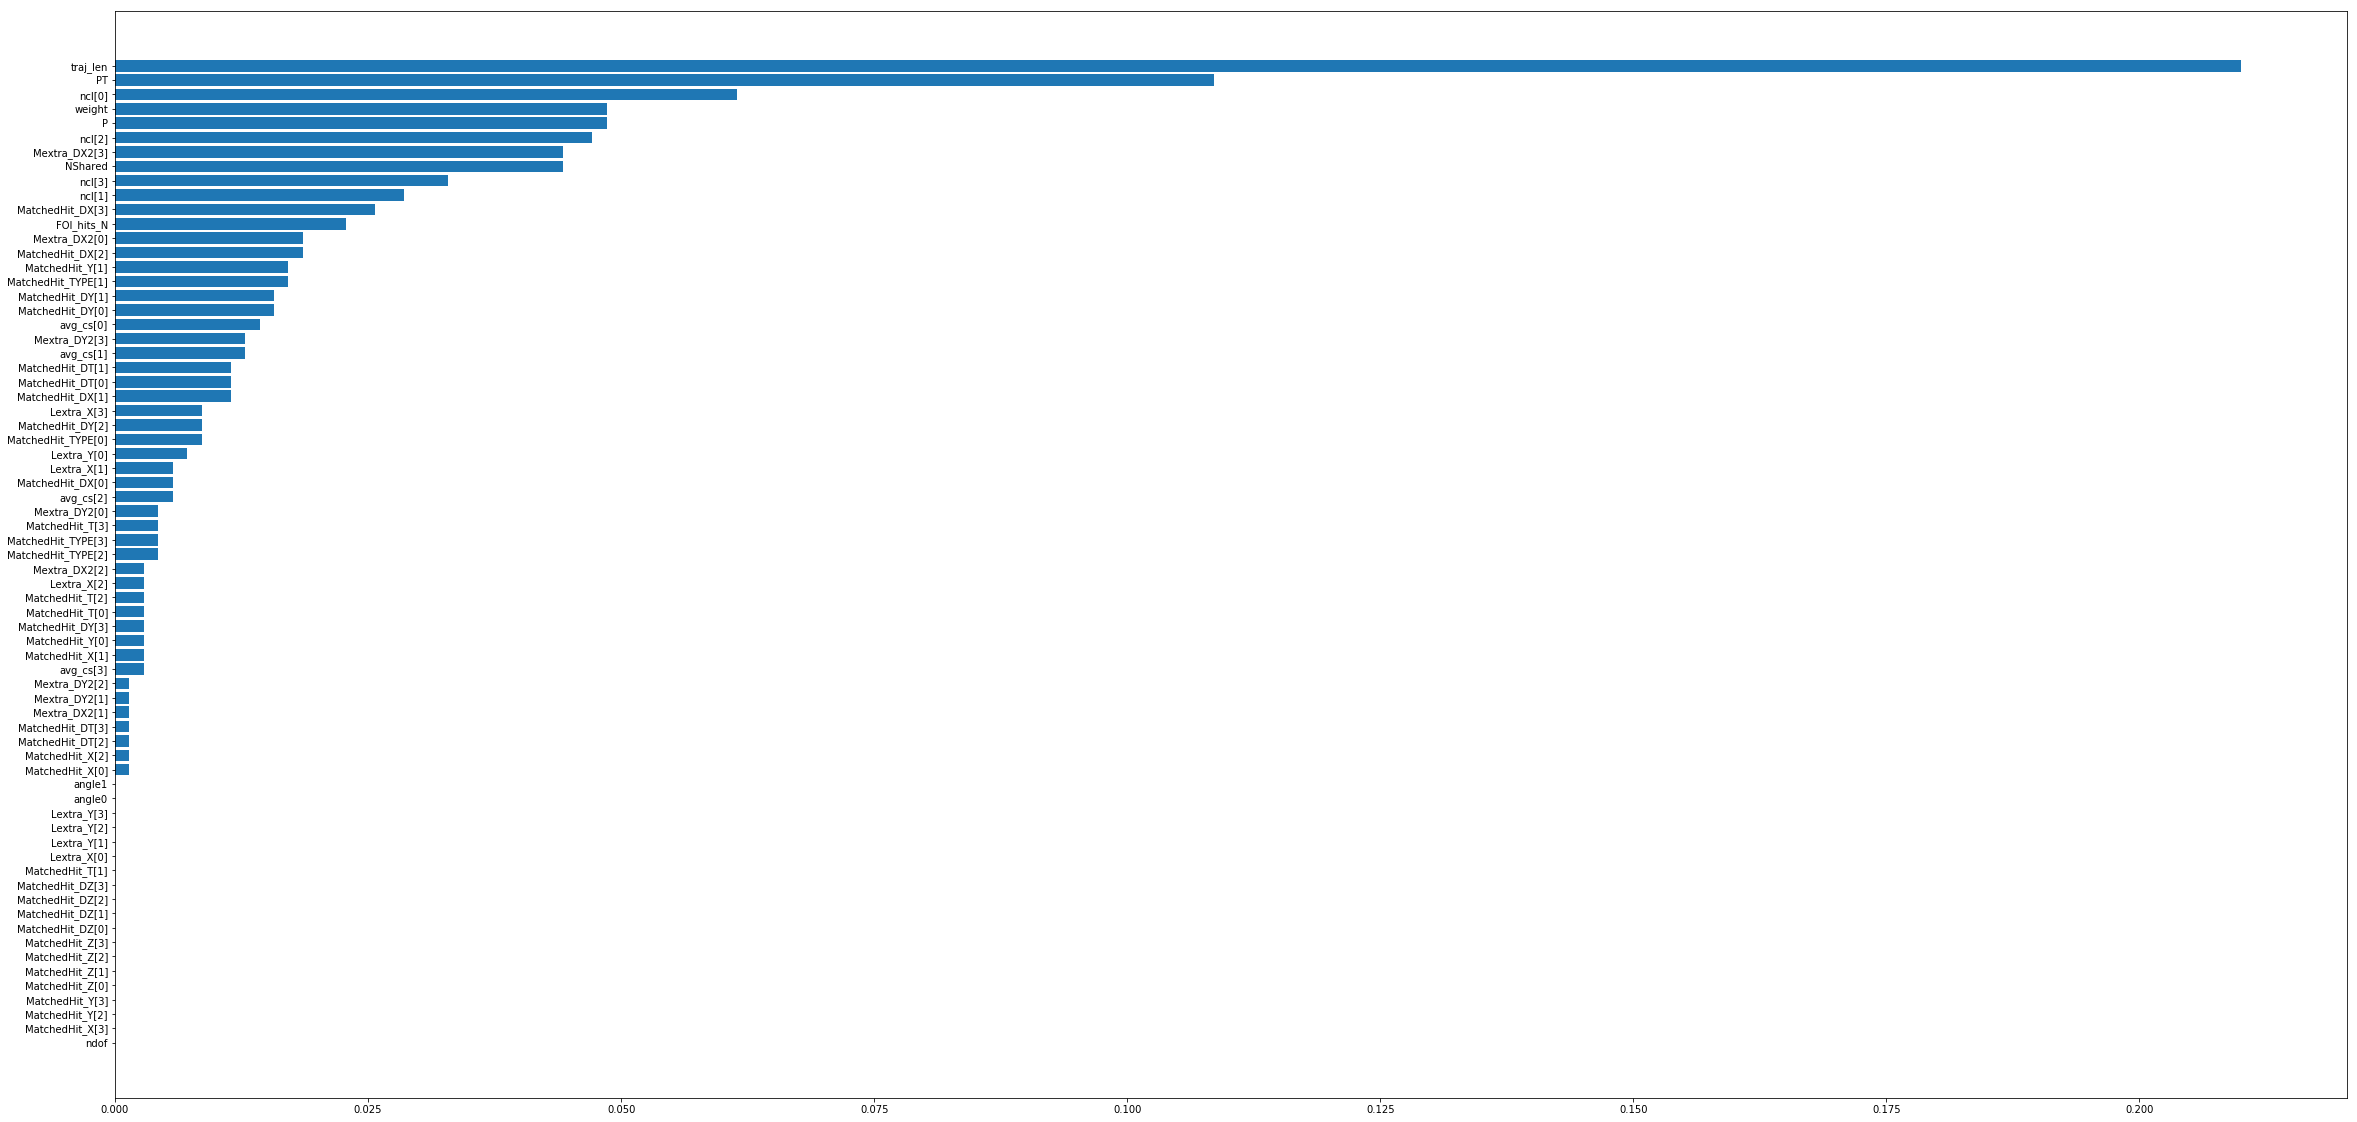

In [20]:
from collections import OrderedDict
from matplotlib import pyplot as plt
%matplotlib inline
feature_dict = {k:v for k,v in zip(model.steps[0][1].SIMPLE_FEATURES, 
                                   model.steps[1][1].estimator.feature_importances_)}
feature_dict = OrderedDict(sorted(feature_dict.items(), key = lambda x:x[1]))

plt.figure(figsize = (40, 20))
plt.barh(list(range(len(feature_dict))), list(feature_dict.values()))
plt.yticks(range(len(feature_dict)), list(feature_dict.keys()))
plt.show()

In [21]:
len(df_test.keys())

79

In [22]:
len(model.steps[0][1].SIMPLE_FEATURES)

70